<a href="https://colab.research.google.com/github/dnaae/spot_detection_/blob/cell-%26-nuclei-segmentation/notebook_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

according to notebook 4, nuc path will correspond to the first channel and cell path will correspond to the FISH channel: try with hardcoded paths

In [1]:
!pip install big-fish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 2.5 MB/s eta 0:00:00


In [2]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

/usr/local/lib/python3.10/dist-packages/bigfish/segmentation/nuc_segmentation.py:16: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


Big-FISH version: 0.6.2


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the top-level folder in your Google Drive
drive_folder = "/content/drive/MyDrive/"


Mounted at /content/drive


In [23]:
path_input = "/content/drive/MyDrive/CPTH2/output/"

In [24]:
# read dapi image
path = os.path.join(path_input, "C1-AVG_MCF7_AREG_CPTH2_501.tif")
# path="/content/drive/MyDrive/DMSO/output/example_nuc_full.tif"
nuc = stack.read_image(path)
print("dapi channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype), "\n")

# read smfish image
path = os.path.join(path_input, "C2-AVG_MCF7_AREG_CPTH2_501.tif")
cell = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(cell.shape))
print("\r dtype: {0}".format(cell.dtype))


dapi channel
 shape: (512, 512)
 dtype: uint16 

smfish channel
 shape: (512, 512)
 dtype: uint16


In [46]:
# thresholding
nuc_mask = segmentation.thresholding(nuc, threshold=200)
nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=500, fill_holes=True)
print("nuclei mask")
print("\r shape: {0}".format(nuc_mask.shape))
print("\r dtype: {0}".format(nuc_mask.dtype), "\n")
# labeling
nuc_label = segmentation.label_instances(nuc_mask)
print("nucleus labels")
print("\r shape: {0}".format(nuc_label.shape))
print("\r dtype: {0}".format(nuc_label.dtype))

nuclei mask
 shape: (512, 512)
 dtype: bool 

nucleus labels
 shape: (512, 512)
 dtype: int64


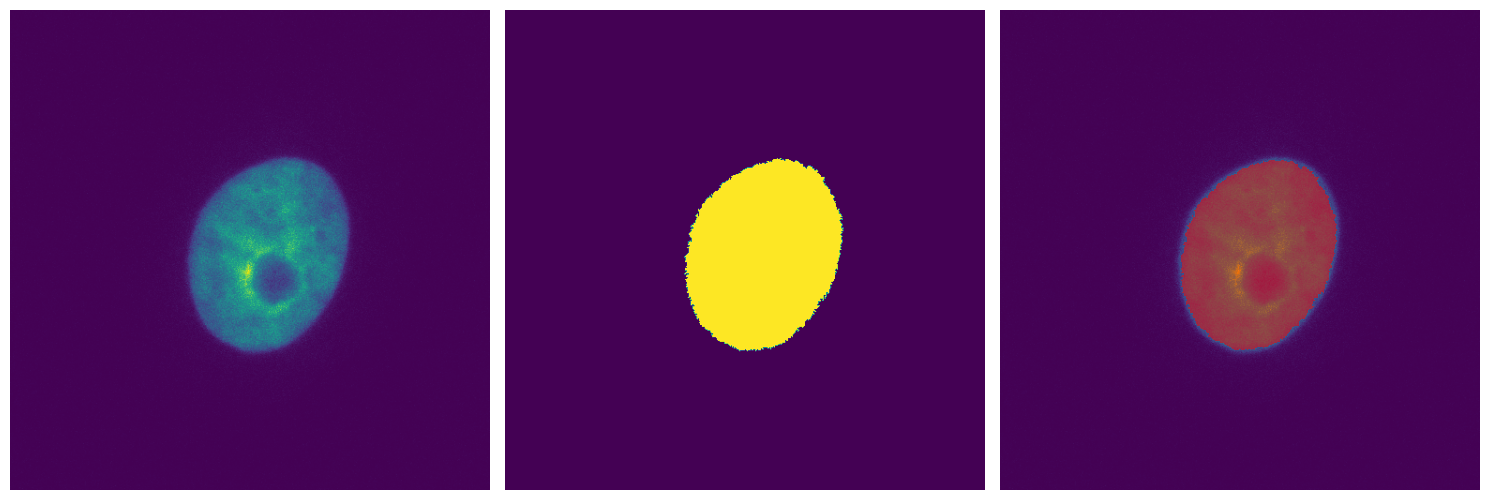

In [47]:
plot.plot_segmentation(nuc, nuc_label, rescale=True)

In [48]:
# apply watershed
cell_label = segmentation.cell_watershed(cell, nuc_label, threshold=200, alpha=0.9)
print("cell labels")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

cell labels
 shape: (512, 512)
 dtype: int64


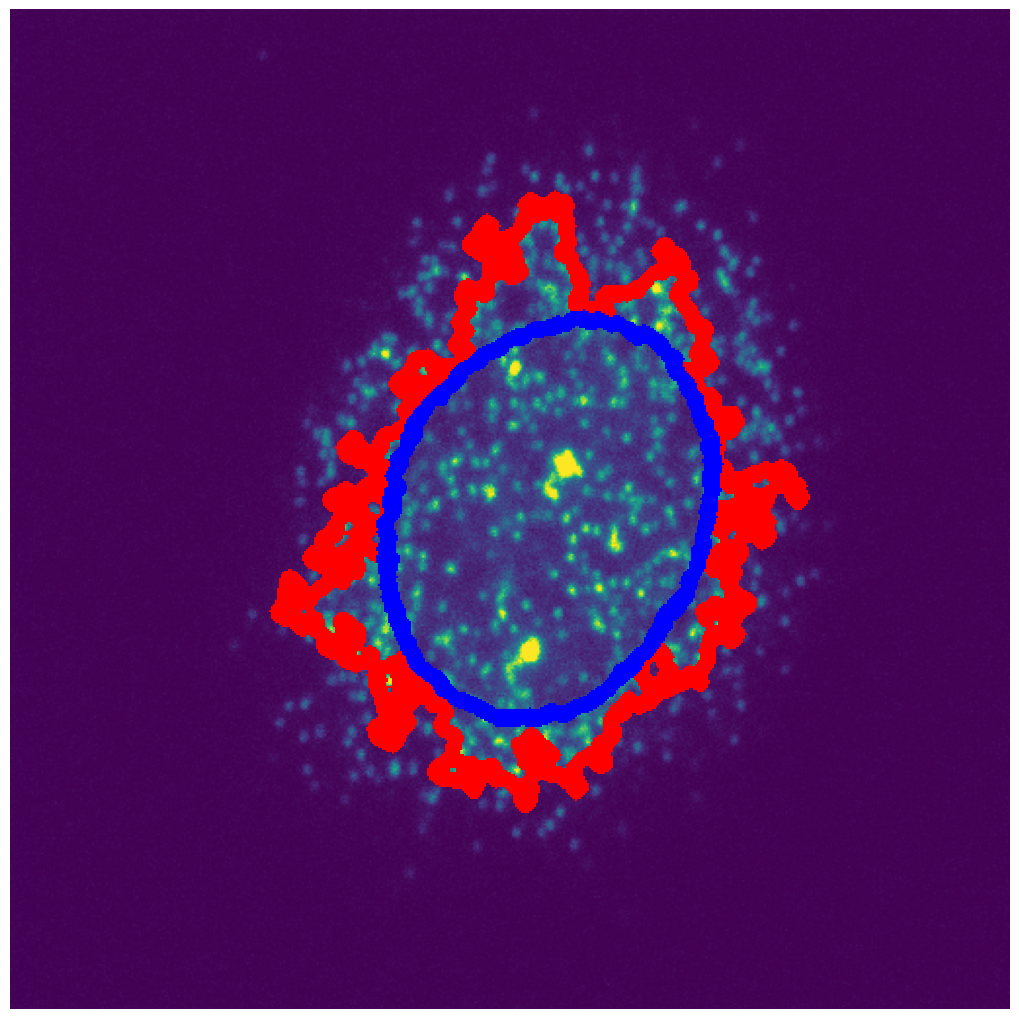

In [49]:
plot.plot_segmentation_boundary(cell, cell_label, nuc_label, contrast=True, boundary_size=4)

In [50]:
# build watershed representation of the cells
watershed_relief = segmentation.get_watershed_relief(cell, nuc_label, alpha=0.9)
print("watershed relief")
print("\r shape: {0}".format(watershed_relief.shape))
print("\r dtype: {0}".format(watershed_relief.dtype), "\n")

# build cell mask
cell_mask = segmentation.thresholding(cell, threshold=200)
cell_mask[nuc_label > 0] = True
cell_mask = segmentation.clean_segmentation(cell_mask,
                                            small_object_size=20,
                                            fill_holes=True)
print("cell mask")
print("\r shape: {0}".format(cell_mask.shape))
print("\r dtype: {0}".format(cell_mask.dtype), "\n")

# apply watershed algorithm
cell_label = segmentation.apply_watershed(watershed_relief, nuc_label, cell_mask)
print("cell labels")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

watershed relief
 shape: (512, 512)
 dtype: uint16 

cell mask
 shape: (512, 512)
 dtype: bool 

cell labels
 shape: (512, 512)
 dtype: int64


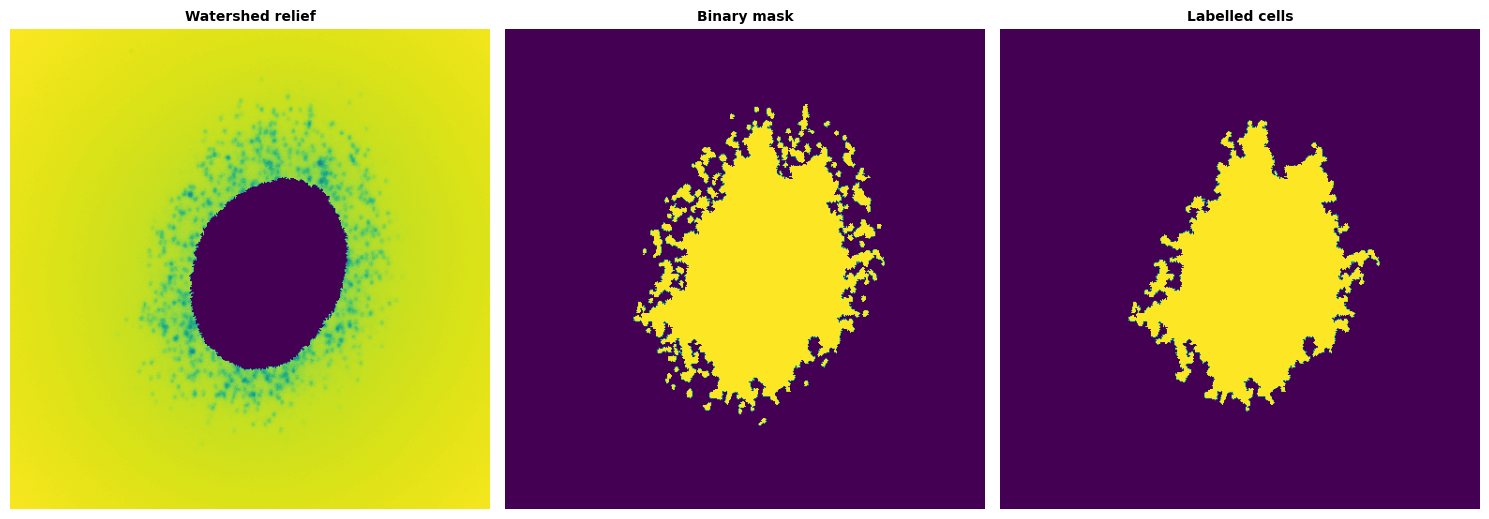

In [51]:
plot.plot_images([watershed_relief, cell_mask, cell_label],
                 titles=["Watershed relief", "Binary mask", "Labelled cells"])

In [52]:
#post-processing
nuc_label = segmentation.clean_segmentation(nuc_label, delimit_instance=True)
cell_label = segmentation.clean_segmentation(cell_label, smoothness=7, delimit_instance=True)
nuc_label, cell_label = multistack.match_nuc_cell(nuc_label, cell_label, single_nuc=False, cell_alone=True)

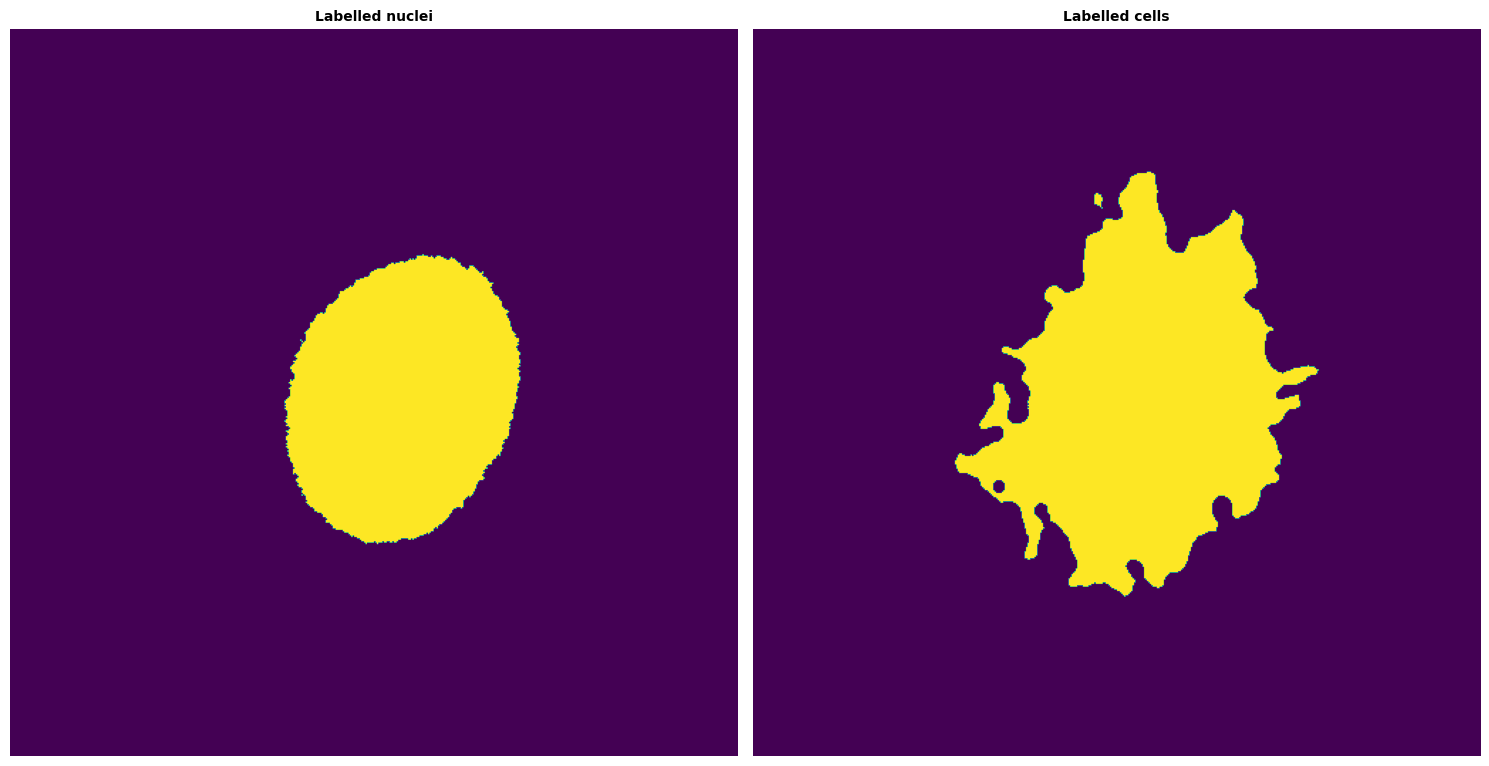

In [53]:
plot.plot_images([nuc_label, cell_label], titles=["Labelled nuclei", "Labelled cells"])

dapi channel
 shape: (512, 512)
 dtype: uint16 

smfish channel
 shape: (512, 512)
 dtype: uint16


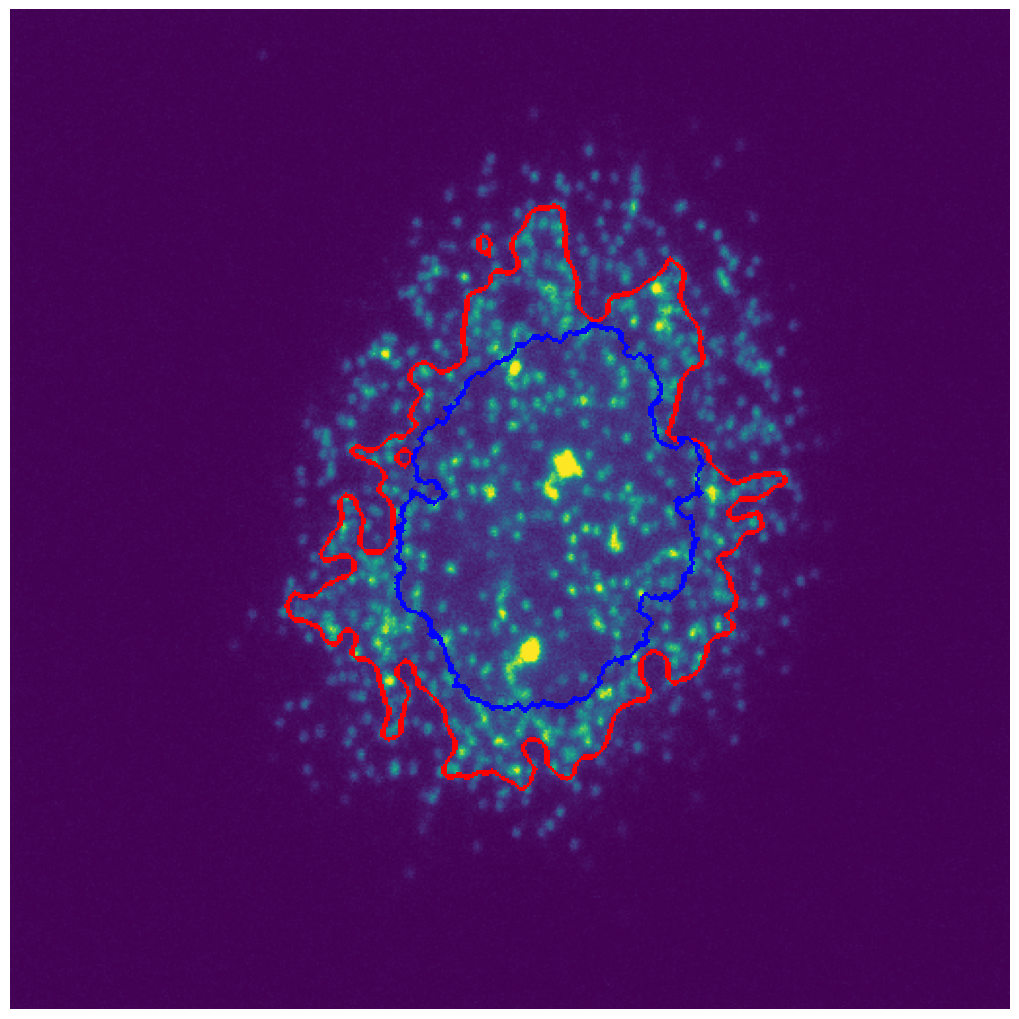

In [56]:
# read dapi image
path = os.path.join(path_input, "C1-AVG_MCF7_AREG_CPTH2_501.tif")
nuc = stack.read_image(path)
print("dapi channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype), "\n")

# read smfish image
path = os.path.join(path_input, "C2-AVG_MCF7_AREG_CPTH2_501.tif")
rna = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

# nucleus segmentation
nuc_mask = segmentation.thresholding(nuc, threshold=270)
nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=500, fill_holes=True)
nuc_label = segmentation.label_instances(nuc_mask)

# cell segmentation
cell_label = segmentation.cell_watershed(rna, nuc_label, threshold=200, alpha=0.9)

# postprocessing
nuc_label = segmentation.clean_segmentation(nuc_label, delimit_instance=True)
cell_label = segmentation.clean_segmentation(cell_label, smoothness=7, delimit_instance=True)
nuc_label, cell_label = multistack.match_nuc_cell(nuc_label, cell_label, single_nuc=False, cell_alone=True)

# plot
plot.plot_segmentation_boundary(rna, cell_label, nuc_label, contrast=True)

# save nucleus and cell labels
path = os.path.join(path_input, "nuc_label_trial.tif")
stack.save_image(nuc_label, path)
path = os.path.join(path_input, "cell_label_trial.tif")
stack.save_image(cell_label, path)